In [12]:
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from imblearn.pipeline import Pipeline

import xgboost as xgb

import pandas as pd

In [2]:
k_folds = 10
rs = 0

In [30]:
flights_weather_spatial_df = pd.read_csv('../data/intermediate/modelling/flights_weather_spatial_average_modelling.csv')
flights_weather_spatial_df = flights_weather_spatial_df.astype(float)

In [31]:
X = flights_weather_spatial_df.drop(columns=['INDEX', 'IS_WEATHER_DELAY'])
y = flights_weather_spatial_df["IS_WEATHER_DELAY"]

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)

### Decision Trees

In [34]:
params = {
    'classifier__max_depth': [2, 4, 6, 8, 10, 20, 30, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# insure no information leaking between train and validation sets by using pipeline
pipeline = Pipeline([
    ('scaler', MinMaxScaler(feature_range=(-1, 1))),  # normalization
    ('classifier', DecisionTreeClassifier(criterion='entropy'))
])

dt_grid_search = GridSearchCV(pipeline, param_grid=params, cv=k_folds)
dt_grid_search.fit(X_train, y_train)

dt_best = dt_grid_search.best_estimator_
print("Pre-pruned Decision Tree Best Params: " + str(dt_grid_search.best_params_))
    
# evaluate the model
df_y_pred = dt_best.predict(X_test)
accuracy = accuracy_score(y_test, df_y_pred)

print("Accuracy: {:.2f}%".format(accuracy * 100))

Pre-pruned Decision Tree Best Params: {'classifier__max_depth': 6, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Accuracy: 73.67%


In [35]:
cm = confusion_matrix(y_test, df_y_pred)

df_cm = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
print(df_cm)

          Predicted 0  Predicted 1
Actual 0          102           45
Actual 1           34          119


### Random Forests

In [36]:
params = {
    'classifier__n_estimators': [100, 200],  # Number of trees in the forest
    'classifier__max_depth': [None, 5, 10],  # Maximum depth of each tree
    'classifier__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'classifier__min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}


pipeline = Pipeline([
    ('scaler', MinMaxScaler(feature_range=(-1, 1))), # normalization
    ('classifier', RandomForestClassifier())
])

rf_grid_search = GridSearchCV(pipeline, param_grid=params, cv=k_folds)
rf_grid_search.fit(X_train, y_train)

rf_best = rf_grid_search.best_estimator_
print("Random Forest Best Params:", rf_grid_search.best_params_)

# evaluate the model
rf_y_pred = rf_best.predict(X_test)
accuracy = accuracy_score(y_test, rf_y_pred)

print("Accuracy: {:.2f}%".format(accuracy * 100))

Random Forest Best Params: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200}
Accuracy: 81.33%


In [37]:
cm = confusion_matrix(y_test, rf_y_pred)

rf_cm = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
print(rf_cm)

          Predicted 0  Predicted 1
Actual 0          111           36
Actual 1           20          133


### Adaboost

In [38]:
params = {
    'classifier__n_estimators': [100, 300],  # Number of estimators (trees)
    'classifier__learning_rate': [0.1, 1.0],  # Learning rate
    'classifier__base_estimator__max_depth': [2, 5],  # Maximum depth of each base estimator (decision tree)
}

pipeline = Pipeline([
    ('scaler', MinMaxScaler(feature_range=(-1, 1))), # normalization
    ('classifier', AdaBoostClassifier(base_estimator=DecisionTreeClassifier()))
])

adaboost_grid_search = GridSearchCV(pipeline, param_grid=params, cv=k_folds)
adaboost_grid_search.fit(X_train, y_train)

adaboost_best = adaboost_grid_search.best_estimator_
print("AdaBoost Best Params:", adaboost_grid_search.best_params_)

# evaluate the model
adaboost_y_pred = adaboost_best.predict(X_test)
accuracy = accuracy_score(y_test, adaboost_y_pred)

print("Accuracy: {:.2f}%".format(accuracy * 100))

AdaBoost Best Params: {'classifier__base_estimator__max_depth': 5, 'classifier__learning_rate': 1.0, 'classifier__n_estimators': 300}
Accuracy: 79.33%


In [39]:
cm = confusion_matrix(y_test, adaboost_y_pred)

adaboost_cm = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
print(adaboost_cm)

          Predicted 0  Predicted 1
Actual 0          109           38
Actual 1           24          129


### XGBoost

In [40]:
params = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.1, 0.2, 0.3],
    'classifier__max_depth': [3, 4, 5]
}

pipeline = Pipeline([
    ('scaler', MinMaxScaler(feature_range=(-1, 1))), # normalization
    ('classifier', xgb.XGBClassifier(random_state=rs))
])

xgboost_grid_search = GridSearchCV(pipeline, params, cv=k_folds, scoring='roc_auc')
xgboost_grid_search.fit(X_train, y_train)

xgboost_best = xgboost_grid_search.best_estimator_
xgboost_best_params = xgboost_grid_search.best_params_
print("XGBoost Best Params:", xgboost_grid_search.best_params_)

# evaluate the model
xgboost_y_pred = xgboost_best.predict(X_test)
accuracy = accuracy_score(y_test, xgboost_y_pred)

print("Accuracy: {:.2f}%".format(accuracy*100))

XGBoost Best Params: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}
Accuracy: 80.00%


In [41]:
cm = confusion_matrix(y_test, xgboost_y_pred)

xgboost_cm = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
print(xgboost_cm)

          Predicted 0  Predicted 1
Actual 0          111           36
Actual 1           24          129


#### Feature Importance Plot

Accuracy: 80.00%


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

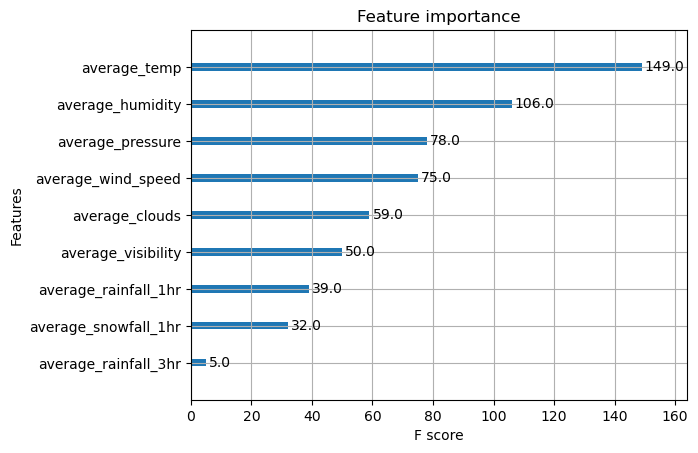

In [43]:
# normalize the training and testing data
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# reassign column names to normalized dataframes as they somehow were removed
X_train_normalized = pd.DataFrame(X_train_normalized, columns=X_train.columns)
X_test_normalized = pd.DataFrame(X_test_normalized, columns=X_test.columns)

xgboost_model = xgb.XGBClassifier(learning_rate = 0.1, max_depth = 3, n_estimators = 100, random_state=rs)
xgboost_model.fit(X_train_normalized, y_train)

# evaluate the model
xgboost_best_y_pred = xgboost_model.predict(X_test_normalized)
accuracy = accuracy_score(y_test, xgboost_best_y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

xgb.plot_importance(xgboost_model)